# Sustainability project - fully stochastic

Code for performing an individual-based, fully stochastic simulation of the CPR sustainability model.\
The system is a fully-connected lattice with N+K sites, where N is the total number of consumers, which we assumed is fixed, and K is the carrying capacity of resources.\
Each site, then, can host:
1. An empty slot, to be occupied by a resource $\leftrightarrow$ value 0
2. A cooperating consumer $\leftrightarrow$ value 1
3. A parcel of resource $\leftrightarrow$ value 2
4. A defecting consumer $\leftrightarrow$ value 3

In [1]:
import sys
sys.path.append('/Users/fabiomenegazzo/Documents/Università/codes')
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as scint
import copy
plt.rcParams['font.size'] = 20
plt.rcParams['pcolor.shading'] = 'auto'
from helpers import *
from Gillespie import *
from CPRsust_rates import *
from extinctionTimes import *
from CPRSust_detEqs import *

# Number of agents
N = 200
# Harvesting rates and corresponding network node states (used within the code)
extractionRates = np.sort(np.array([0.1,1.1]))
# Each node represents either a consumer (cooperator or defector) or a slot of resource (full or empty)
nodeStates = [0,1,2,3]
stateLabels = ['hole','resource','cooperator','defector']
# Carrying capacity of resource in terms of number of quanta of resource
K = 5*N
# Resource's birth rate
b = 1.
# We will assume that all nodes are connected

# Settings for numerical simulations
# Initial conditions
x0 = 0.5
R0 = 0.5

# Length of the simulation
tMax_detRes = 80

# Number of repetitions of the simulation
NReps_detRes = 10

# Tolerance for the evaluation of the extinction times
tolerance = 1e-3

## Benchmark: mean field model

Evaluating the time to extinction
	Done.


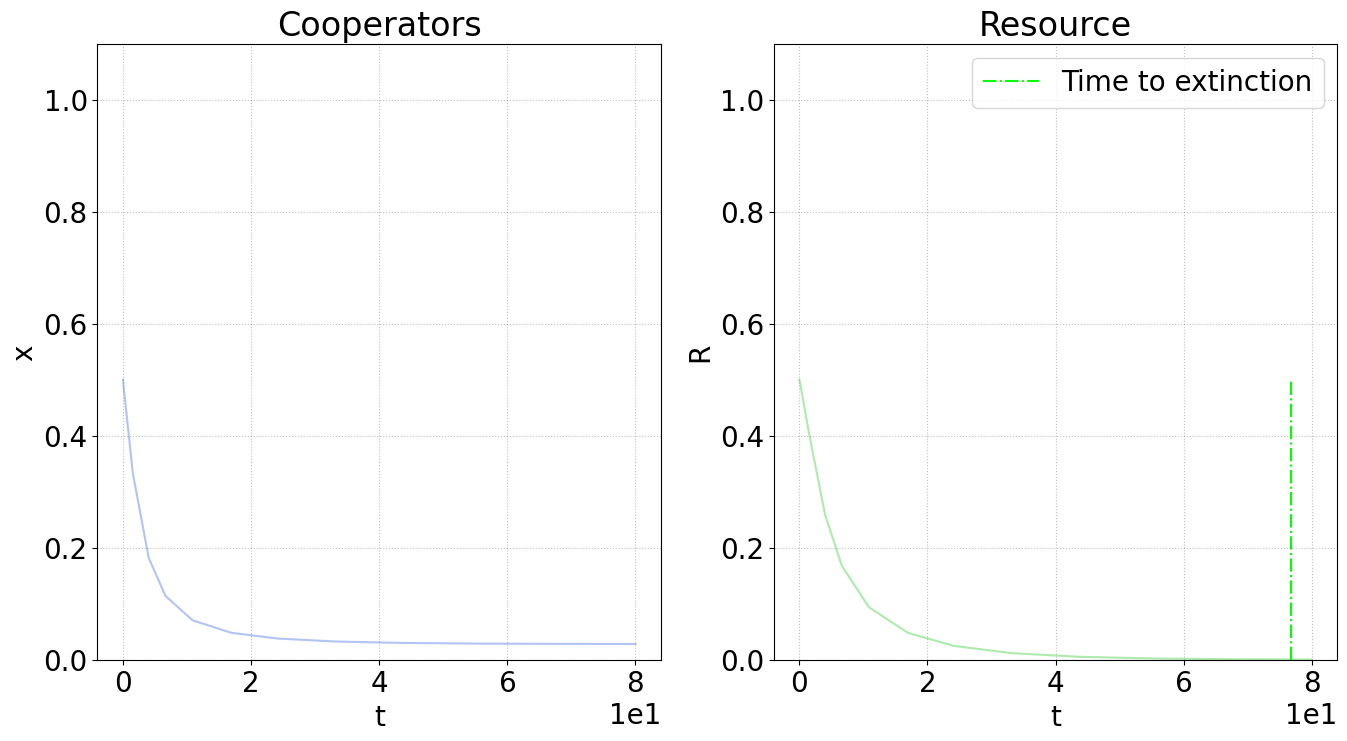

In [ ]:
# Define the context object to be used with all integrators in the rest of the code
context_MF = {
    'b' : b,
    'extractionRates' : extractionRates,
    'N' : N
}

paramsString = ['b','extractionRates']
params = evalContextVar(paramsString,context_MF)

zSeries = scint.solve_ivp(HES,[0,tMax_detRes],[R0,x0],method='RK45',args=(params))

# Unpack the resulting object
seriesObj_MF = {
    'time' : zSeries.t,
    'cooperators' : zSeries.y[1],
    'resource' : zSeries.y[0]
    }

# Time to extinction
print('Evaluating the time to extinction')
tExt_MF = extinctionTime_single(seriesObj_MF['time'],seriesObj_MF['resource'],tolerance)
if not tExt_MF:
    print('\tDone. The resource remains sustainable!')
    seriesObj_MF['absorbing'] = False
else:
    seriesObj_MF['absorbing'] = True
print('\tDone.')

plotsObj = [
    {
        'name' : 'Cooperators',
        'x' : seriesObj_MF['time'],
        'y': seriesObj_MF['cooperators'],
        'color' : 'royalblue',
        'xlabel' : 't',
        'ylabel' : 'x',
        'yLims' : [0, 1.1]
    },
    {
        'name' : 'Resource',
        'x' : seriesObj_MF['time'],
        'y' : seriesObj_MF['resource'],
        'color' : 'limegreen',
        'xlabel' : 't',
        'ylabel' : 'R',
        'yLims' : [0,1.1]
    }
]

fig_MF, ax_MF = plt.subplots(1,2,figsize=(16,8))

for ax,plotObj in zip(ax_MF,plotsObj):
    ax.set_title(plotObj['name'])
    ax.plot(plotObj['x'],plotObj['y'],plotObj['color'], alpha=0.4)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(plotObj['xlabel'])
    ax.set_ylabel(plotObj['ylabel'])
    ax.set_ylim(plotObj['yLims'])
    ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
if tExt_MF:
    ax_MF[1].vlines(tExt_MF,0,R0,colors='lime',linestyle='-.',label='Time to extinction')
    ax_MF[1].legend()
plt.show()

## Step back: the mixed model

For starting, we regard the dynamics on the consumers as stochastic and the resource as deterministic.

In [3]:
# Update context
context_detRes = copy.deepcopy(context_MF)
context_detRes['nodeStates'] = nodeStates

# Vector of consumers (agents only, for now)
zVec_detRes = np.ones(N,dtype=int)
# Vector of consumers - assignment of initial conditions
zVec_detRes[0:int(N*x0)] = setVec(zVec_detRes[0:int(N*x0)],nodeStates[2])
zVec_detRes[int(N*x0):N] = setVec(zVec_detRes[int(N*x0):N],nodeStates[3])

reactsCPRsust_homogeneous_detRes = [
    {
        'description': 'Change of strategy: cooperator to defector',
        'probFunc' : rateMinus_detRes,
        'probFuncVars' : ['R','varVec','N','nodeStates[2]','nodeStates[3]'],
        'oldState' : ['nodeStates[2]'],
        'newState' : ['nodeStates[3]']
    },
    {
        'description': 'Change of strategy: defector to cooperator',
        'probFunc' : ratePlus_detRes,
        'probFuncVars' : ['R','varVec','N','nodeStates[2]','nodeStates[3]'],
        'oldState' : ['nodeStates[3]'],
        'newState' : ['nodeStates[2]']
    }
]

def RNew_Gillespie(context,Dt):
    b = evalContextVar(['b'],context)[0]
    R = evalContextVar(['R'],context)[0]
    z = evalContextVar(['varVec'],context)[0]
    x = len(getSubvec(z,evalContextVar(['nodeStates'],context)[0][1]))/len(z)
    extractionRates = evalContextVar(['extractionRates'],context)[0]
    harvestTerm = x*extractionRates[0] + (1-x)*extractionRates[1]
    KEff = 1 - harvestTerm
    bEff = b * KEff
    A = (KEff-R)/R
    return KEff/(1 + A*np.exp(-bEff*Dt))

In [4]:
print('Launching the simulation')

seriesObj_detRes = []

for kRep in range(NReps_detRes):
    # Reset the vatiables of the context to their initial conditions
    context_detRes['R'] = R0
    context_detRes['varVec'] = zVec_detRes

    print(f'\tLaunching repetition {kRep+1} of {NReps_detRes}')
    kStep = 1
    tSim_detRes_temp = [0]
    vecSim_detRes_temp = [evalContextVar(['varVec'],context_detRes)[0]]
    RSim_detRes_temp = [evalContextVar(['R'],context_detRes)[0]]

    while tSim_detRes_temp[-1] < tMax_detRes:
        # Number of iteration
        # print(kRep+1)

        # Single iteration of the Gillespie algorithm
        absState, objNew = GillespieStep(context_detRes,reactsCPRsust_homogeneous_detRes)
        if absState:
            print('\t\tThe simulation reached an absorbing state. Stopping the simulation.')
            break

        # Update time
        tProcess = objNew['t']
        tSim_detRes_temp.append(tSim_detRes_temp[-1] + tProcess)
        # print('\ttime:',tSim_detRes[-1][-1])

        # Update variables
        vecSim_detRes_temp.append(objNew['vec'])
        # print('\tnumber of cooperators',countSpecies(vecSim_detRes[-1],nodeStates[1]))

        # Update the resource deterministically
        RNew = RNew_Gillespie(context_detRes,tProcess)
        RSim_detRes_temp.append(RNew)
        context_detRes['R'] = RNew
        # print('\tResource',RNew)

        # Increase counter
        kStep+=1
    seriesObj_detRes.append({
        'time' : tSim_detRes_temp,
        'cooperators' : [speciesFrac(z,nodeStates[2]) for z in vecSim_detRes_temp],
        'resource' : RSim_detRes_temp,
        'absorbing' : absState
        })

    print(f'\t\tRepetition {kRep+1} completed\n\t\t{len(tSim_detRes_temp)} steps have been performed')

# Reset context
context_detRes['R'] = R0
context_detRes['varVec'] = zVec_detRes

print('Done')

Launching the simulation
	Launching repetition 1 of 10
		Repetition 1 completed
		2246 steps have been performed
	Launching repetition 2 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 2 completed
		801 steps have been performed
	Launching repetition 3 of 10
		Repetition 3 completed
		3397 steps have been performed
	Launching repetition 4 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 4 completed
		759 steps have been performed
	Launching repetition 5 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 5 completed
		875 steps have been performed
	Launching repetition 6 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 6 completed
		2155 steps have been performed
	Launching repetition 7 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 7 completed
		559 steps have been performed
	Launching re

Evaluating the times to extinction
	Done. 70.0% of the repetitions achieved extinction.


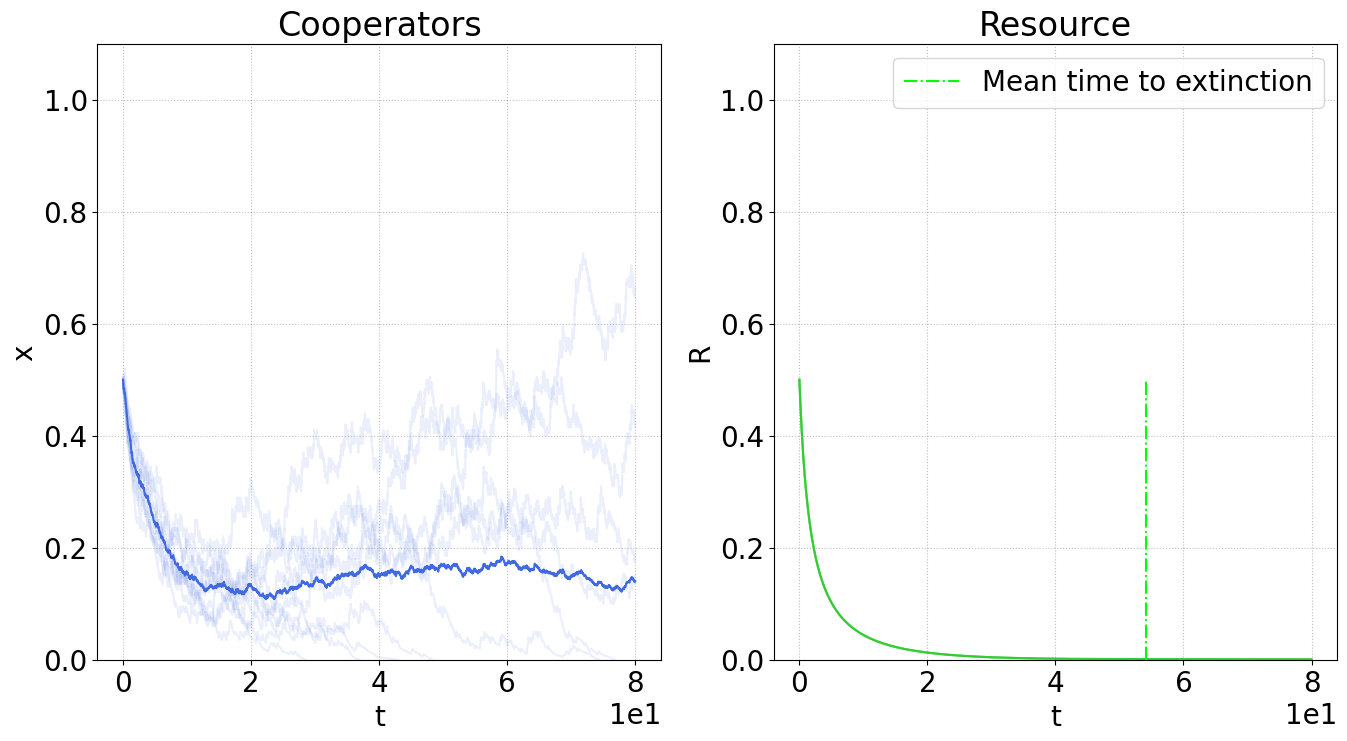

In [ ]:
# Statistics of the times to extinction
print('Evaluating the times to extinction')
tExtObj_detRes = extinctionTimes(seriesObj_detRes)
if not tExtObj_detRes['mean']:
    print('\tDone. The resource remains sustainable!')
else:
    print(f'\tDone. {tExtObj_detRes['fraction']*100}% of the repetitions achieved extinction.')

# Calculate averages
if all(len(obj['time']) == 1 for obj in seriesObj_detRes):
    seriesObj_detRes = [seriesObj_MF.copy() for _ in range(NReps_detRes)]
    tSimAvg_detRes = seriesObj_MF['time'].copy()    
else:
    tSimAvg_detRes = tVecCommon(seriesObj_detRes,context_detRes,reactsCPRsust_homogeneous_detRes)
coopFracSeriesInterp_detRes = GillTimeSeriesInterp(tSimAvg_detRes,seriesObj_detRes,'cooperators')
coopFracSeriesAvg_detRes = np.mean(coopFracSeriesInterp_detRes,axis=0)
RSimInterp_detRes = GillTimeSeriesInterp(tSimAvg_detRes,seriesObj_detRes,'resource')
RSimAvg_detRes = np.mean(RSimInterp_detRes,axis=0)

plotsObj = [
    {
        'name' : 'Cooperators',
        'series': [obj['cooperators'] for obj in seriesObj_detRes],
        'color' : 'royalblue',
        'xlabel' : 't',
        'ylabel' : 'x',
        'yLims' : [0, 1.1]
    },
    {
        'name' : 'Resource',
        'series' : [obj['resource'] for obj in seriesObj_detRes],
        'color' : 'limegreen',
        'xlabel' : 't',
        'ylabel' : 'R',
        'yLims' : [0, 1.1]
    }
]

fig_detRes_Avg, ax_detRes_Avg = plt.subplots(1,2,figsize=(16,8))
for ax,plotObj in zip(ax_detRes_Avg,plotsObj):
    ax.set_title(plotObj['name'])
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(plotObj['xlabel'])
    ax.set_ylabel(plotObj['ylabel'])
    ax.set_ylim(plotObj['yLims'])
    for kRep in range(NReps_detRes):
        ax.plot(seriesObj_detRes[kRep]['time'],plotObj['series'][kRep],plotObj['color'], alpha=0.1)
    ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
ax_detRes_Avg[0].plot(tSimAvg_detRes,coopFracSeriesAvg_detRes,color=plotsObj[0]['color'])
ax_detRes_Avg[1].plot(tSimAvg_detRes,RSimAvg_detRes,color=plotsObj[1]['color'])
if tExtObj_detRes['mean']:
    ax_detRes_Avg[1].vlines(tExtObj_detRes['mean'],0,R0,colors='lime',linestyle='-.',label='Mean time to extinction')
    ax_detRes_Avg[1].legend()

plt.show()

## Fully stochastic model

Now we regard the resource as stochastic as well

In [6]:
# Define the reactions object to be used with the Gillespie function
reactsCPRsust_homogeneous_stocRes = [
    {
        'description': 'Offspring of resource',
        'probFunc' : resBirthRate,
        'probFuncVars' : ['varVec','b','K','nodeStates[1]'],
        'oldState' : ['nodeStates[0]'],
        'newState' : ['nodeStates[1]']
    },
    {
        'description': 'Change of strategy: cooperator to defector',
        'probFunc' : rateMinus,
        'probFuncVars' : ['varVec','K','nodeStates[1]','N','nodeStates[2]','nodeStates[3]'],
        'oldState' : ['nodeStates[2]'],
        'newState' : ['nodeStates[3]']
    },
    {
        'description' : 'Resource uptake by cooperator',
        'probFunc' : uptakeRate,
        'probFuncVars' : ['varVec','N','extractionRates[0]','nodeStates[1]','nodeStates[2]'],
        'oldState' : ['nodeStates[1]'],
        'newState' : ['nodeStates[0]']
    },
    {
        'description' : 'Resource uptake by defector',
        'probFunc' : uptakeRate,
        'probFuncVars' : ['varVec','N','extractionRates[-1]','nodeStates[1]','nodeStates[3]'],
        'oldState' : ['nodeStates[1]'],
        'newState' : ['nodeStates[0]']
    },
    {
        'description': 'Change of strategy: defector to cooperator',
        'probFunc' : ratePlus,
        'probFuncVars' : ['varVec','K','nodeStates[1]','N','nodeStates[2]','nodeStates[3]'],
        'oldState' : ['nodeStates[3]'],
        'newState' : ['nodeStates[2]']
    }
]

context_stocRes = copy.deepcopy(context_detRes)
context_stocRes['K'] = K

tMax_stocRes = tMax_detRes

NReps_stocRes = 10

# Full vector of individuals (agents + resource) - initialization of var
zVec_stocRes = np.ones(N+K,dtype=int)
# Vector of individuals - assignment of initial conditions
zVec_stocRes[0:int(N*x0)] = setVec(zVec_stocRes[0:int(N*x0)],nodeStates[2])
zVec_stocRes[int(N*x0):N] = setVec(zVec_stocRes[int(N*x0):N],nodeStates[3])
zVec_stocRes[N:N+int(K*R0)] = setVec(zVec_stocRes[N:N+int(K*R0)],nodeStates[1])
zVec_stocRes[N+int(K*R0):] = setVec(zVec_stocRes[N+int(K*R0):],nodeStates[0])

In [7]:
print('Launching the simulation')

seriesObj_stocRes = []

for kRep in range(NReps_stocRes):
    # Reset the vatiables of the context to their initial conditions
    context_stocRes['varVec'] = zVec_stocRes

    print(f'\tLaunching repetition {kRep+1} of {NReps_stocRes}')
    kStep = 1
    tSim_stocRes_temp = [0] 
    vecSim_stocRes_temp = [evalContextVar(['varVec'],context_stocRes)[0]]

    while tSim_stocRes_temp[-1] < tMax_stocRes:
        # Number of iteration
        # print(kRep+1)

        # Single iteration of the Gillespie algorithm
        absState, objNew = GillespieStep(context_stocRes,reactsCPRsust_homogeneous_stocRes)
        if absState:
            print('\t\tThe simulation reached an absorbing state. Stopping the simulation.')
            break

        # Update time
        tProcess = objNew['t']
        tSim_stocRes_temp.append(tSim_stocRes_temp[-1] + tProcess)

        # Update variables
        vecSim_stocRes_temp.append(objNew['vec'])

        # Increase counter
        kStep+=1

    seriesObj_stocRes.append({
        'time' : tSim_stocRes_temp,
        'cooperators' : [countSpecies(z,nodeStates[2])/N for z in vecSim_stocRes_temp],
        'resource' : [countSpecies(z,nodeStates[1])/K for z in vecSim_stocRes_temp],
        'absorbing' : absState
    })
    print(f'\t\tRepetition {kRep+1} completed\n\t\t{len(tSim_stocRes_temp)} steps have been performed')

# Reset context
context_stocRes['varVec'] = zVec_stocRes

print('Done')

Launching the simulation
	Launching repetition 1 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 1 completed
		5935 steps have been performed
	Launching repetition 2 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 2 completed
		4777 steps have been performed
	Launching repetition 3 of 10
		Repetition 3 completed
		6383 steps have been performed
	Launching repetition 4 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 4 completed
		5763 steps have been performed
	Launching repetition 5 of 10
		Repetition 5 completed
		7242 steps have been performed
	Launching repetition 6 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 6 completed
		8123 steps have been performed
	Launching repetition 7 of 10
		The simulation reached an absorbing state. Stopping the simulation.
		Repetition 7 completed
		8329 steps have been performed
	Launchin

Evaluating the times to extinction
	Done. 100.0% of the repetitions achieved extinction.


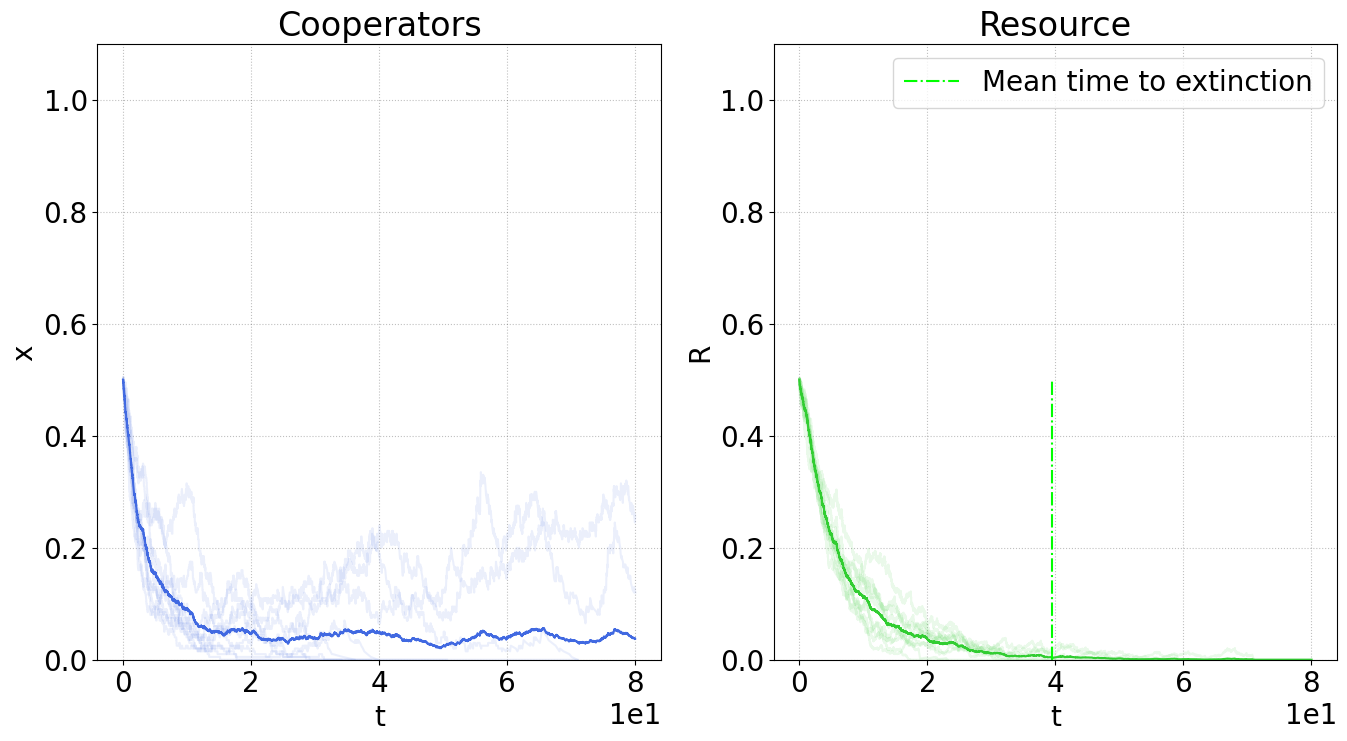

In [8]:
# Statistics of the times to extinction
print('Evaluating the times to extinction')
tExtObj_stocRes = extinctionTimes(seriesObj_stocRes)
if not tExtObj_stocRes['mean']:
    print('\tDone. The resource remains sustainable!')
else:
    print(f'\tDone. {tExtObj_stocRes['fraction']*100}% of the repetitions achieved extinction.')

# Calculate averages
tSimAvg_stocRes = tVecCommon(seriesObj_stocRes,context_stocRes,reactsCPRsust_homogeneous_stocRes)
coopFracSeriesInterp_stocRes = GillTimeSeriesInterp(tSimAvg_stocRes,seriesObj_stocRes,'cooperators')
coopFracSeriesAvg_stocRes = np.mean(coopFracSeriesInterp_stocRes,axis=0)
RSeriesInterp_stocRes = GillTimeSeriesInterp(tSimAvg_stocRes,seriesObj_stocRes,'resource')
RSeriesAvg_stocRes = np.mean(RSeriesInterp_stocRes,axis=0)

plotsObj = [
    {
        'name' : 'Cooperators',
        'series': [obj['cooperators'] for obj in seriesObj_stocRes],
        'color' : 'royalblue',
        'xlabel' : 't',
        'ylabel' : 'x',
        'yLims' : [0, 1.1]
    },
    {
        'name' : 'Resource',
        'series' : [obj['resource'] for obj in seriesObj_stocRes],
        'color' : 'limegreen',
        'xlabel' : 't',
        'ylabel' : 'R',
        'yLims' : [0, 1.1]
    }
]

fig_stocRes_Avg, ax_stocRes_Avg = plt.subplots(1,2,figsize=(16,8))

for ax,plotObj in zip(ax_stocRes_Avg,plotsObj):
    ax.set_title(plotObj['name'])
    for kRep in range(NReps_stocRes):
        ax.plot(seriesObj_stocRes[kRep]['time'],plotObj['series'][kRep],plotObj['color'], alpha=0.1)
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(plotObj['xlabel'])
    ax.set_ylabel(plotObj['ylabel'])
    ax.set_ylim(plotObj['yLims'])
    ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
ax_stocRes_Avg[0].plot(tSimAvg_stocRes,coopFracSeriesAvg_stocRes,color=plotsObj[0]['color'])
ax_stocRes_Avg[1].plot(tSimAvg_stocRes,RSeriesAvg_stocRes,color=plotsObj[1]['color'])
if tExtObj_stocRes['mean']:
    ax_stocRes_Avg[1].vlines(tExtObj_stocRes['mean'],0,R0,colors='lime',linestyle='-.',label='Mean time to extinction')
    ax_stocRes_Avg[1].legend()

plt.show()

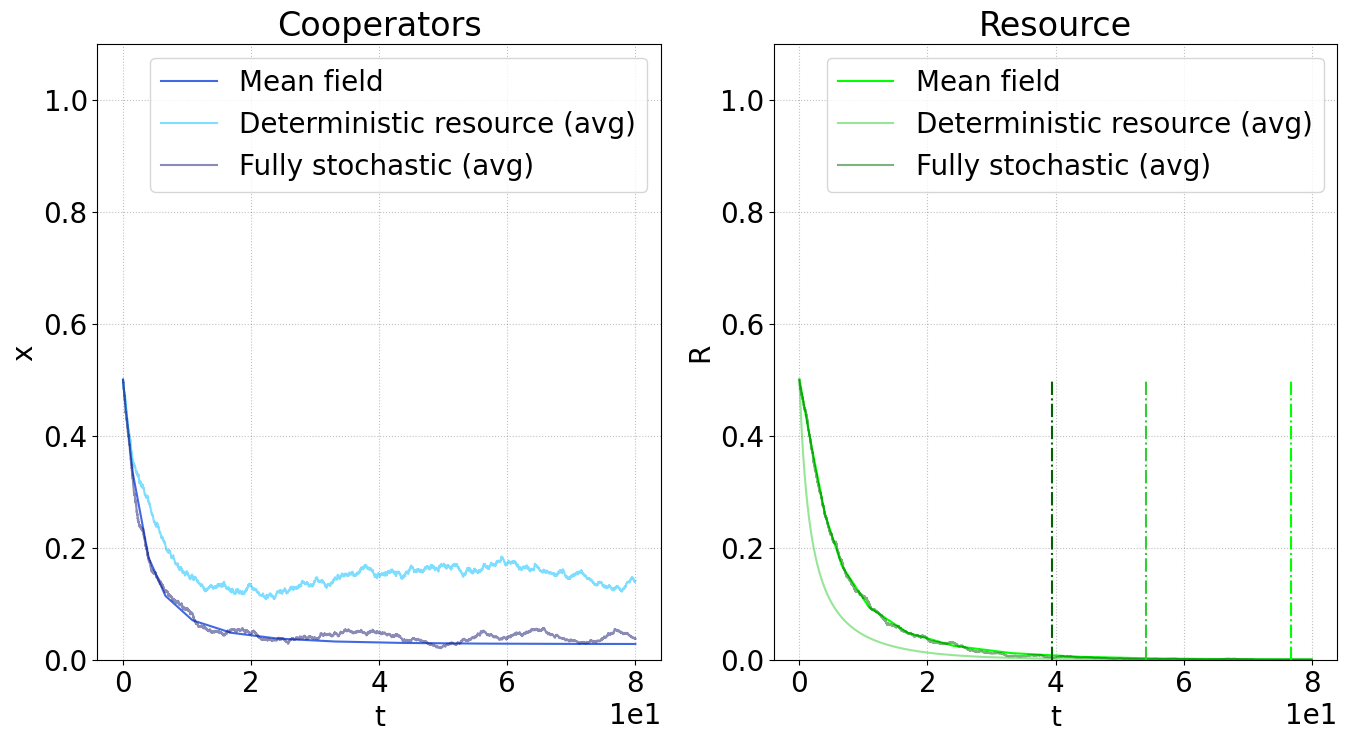

In [ ]:
plotsObj_comp = [
    {
        'name' : 'Cooperators',
        'labels' : ['Mean field','Deterministic resource (avg)','Fully stochastic (avg)'],
        'x' : [seriesObj_MF['time'], tSimAvg_detRes, tSimAvg_stocRes],
        'y': [seriesObj_MF['cooperators'], coopFracSeriesAvg_detRes, coopFracSeriesAvg_stocRes],
        'colors' : ['royalblue','deepskyblue','midnightblue'],
        'alphas' : [1,0.5,0.5],
        'xlabel' : 't',
        'ylabel' : 'x',
        'yLims' : [0, 1.1]
    },
    {
        'name' : 'Resource',
        'labels' : ['Mean field','Deterministic resource (avg)','Fully stochastic (avg)'],
        'x' : [seriesObj_MF['time'], tSimAvg_detRes, tSimAvg_stocRes],
        'xExt' : [tExt_MF, tExtObj_detRes['mean'], tExtObj_stocRes['mean']],
        'y' : [seriesObj_MF['resource'], RSimAvg_detRes, RSeriesAvg_stocRes],
        'colors' : ['lime','limegreen','darkgreen'],
        'alphas' : [1,0.5,0.5],
        'xlabel' : 't',
        'ylabel' : 'R',
        'yLims' : [0, 1.1]
    }
]

fig_comp, ax_comp = plt.subplots(1,2,figsize=(16,8))

for ax,plotObj in zip(ax_comp,plotsObj_comp):
    ax.set_title(plotObj['name'])
    for t,y,col,a,l in zip (plotObj['x'],plotObj['y'],plotObj['colors'],plotObj['alphas'],plotObj['labels']):
        ax.plot(t,y,color=col,alpha=a,label=l)
    ax.legend()
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax.set_xlabel(plotObj['xlabel'])
    ax.set_ylabel(plotObj['ylabel'])
    ax.set_ylim(plotObj['yLims'])
    ax.grid(which='both',linestyle=':',color='k',alpha=0.25)
for tExt,col in zip(plotsObj_comp[1]['xExt'],plotsObj_comp[1]['colors']):
    if tExt:
        ax_comp[1].vlines(tExt,0,R0,colors=col,linestyle='-.')

plt.show()